In [2]:
import pandas as pd
import re
import numpy as np
import matplotlib.pyplot as plt


In [3]:
df = pd.read_csv('raw_time_data.csv')
#tvm_func,compiler_name,microseconds,shape

tvm_func_to_time = {}
for index, row in df.iterrows():
    tvm_func_to_time.setdefault(row['tvm_func'], ([],[]))
    tvm_func_to_time[row['tvm_func']][0].append(row['microseconds'] * 1e-6)
    tvm_func_to_time[row['tvm_func']][1].append(row['shape'])

    if row['compiler_name'] == 'matmul':
        print (row)


# print(len(tvm_func_to_time))
# for i in tvm_func_to_time.keys():
#     print (i)


tvm_func               tvmgen_default_fused_nn_batch_matmul
compiler_name                                        matmul
microseconds                                       0.402792
shape            [[[12, 2, 64], [12, 2, 64]], [[12, 2, 2]]]
Name: 20, dtype: object
tvm_func             tvmgen_default_fused_nn_batch_matmul_1
compiler_name                                        matmul
microseconds                                       6.895092
shape            [[[12, 2, 2], [12, 64, 2]], [[12, 2, 64]]]
Name: 25, dtype: object
tvm_func               tvmgen_default_fused_nn_batch_matmul
compiler_name                                        matmul
microseconds                                       0.746284
shape            [[[12, 3, 64], [12, 3, 64]], [[12, 3, 3]]]
Name: 59, dtype: object
tvm_func             tvmgen_default_fused_nn_batch_matmul_1
compiler_name                                        matmul
microseconds                                       1.466702
shape            [[[12, 3, 3

In [4]:
# Eventually import from hardware
# time and dimentions
def ten_elm(tensor_shape):
    """
    Args:
        tensor_shape (lsit or tuple)

    Returns:
        int: number of elements
    """
    ans = 1
    for dimention in tensor_shape:
        ans *= dimention
    return ans

def _cpu_matmul_cycles(i, o):
    num_dot_products = ten_elm(o[0])
    length_dot_products = i[0][-1]
    num_mac = num_dot_products * length_dot_products
    return num_mac

def all_elm(i, o):
    return ten_elm(o[0])


In [17]:
def plot_func(funcs):
    times = []
    shapes = []
    for f in funcs:
        time, shape = tvm_func_to_time[f]

        times.extend(time)
        shapes.extend(shape)

        # if any('[2' in s for s in shape):
        #     times.extend(time)
        #     shapes.extend(shape)

    shapes = [eval(s) for s in shapes]
    macs = [_cpu_matmul_cycles(*s) for s in shapes]

    print(f'mac_positive: {all(m > 0 for m in macs)}')
    print(f'time_positive: {all(t > 0 for t in times)}')

    time_per_mac = [times[idx]/num_macs for idx, num_macs in enumerate(macs)]

    macs = np.array(macs)
    times = np.array(times)

    m, b = np.polyfit(macs, times, 1)

    y_pred = m * macs + b
    ss_res = np.sum((times - y_pred) ** 2)
    ss_tot = np.sum((times - np.mean(times)) ** 2)
    r_squared = 1 - (ss_res / ss_tot)

    print(f'{funcs}')
    print(f'{r_squared}')
    print(f'y = {m} x + {b}')

    plt.scatter(macs, times, color='blue', label='macs')
    # plt.scatter(macs, time_per_mac, color='red', label='time/mac')

    plt.plot(macs, m*macs + b, color='red', label='Fitted Line')

    plt.xlabel('size')
    plt.ylabel('time')
    plt.title('no')
    plt.legend()
    plt.show()

    print(min(macs))
    print(max(macs))
    time = m * min(macs) + b
    assert time > 0

    return m, b


mac_positive: True
time_positive: True
['tvmgen_default_fused_nn_batch_matmul', 'tvmgen_default_fused_nn_batch_matmul_1', 'tvmgen_default_fused_nn_dense', 'tvmgen_default_fused_nn_dense_1', 'tvmgen_default_fused_nn_dense_2', 'tvmgen_default_fused_nn_dense_3']
0.9700458926665285
y = 6.845684637179875e-11 x + 8.258292187675319e-07


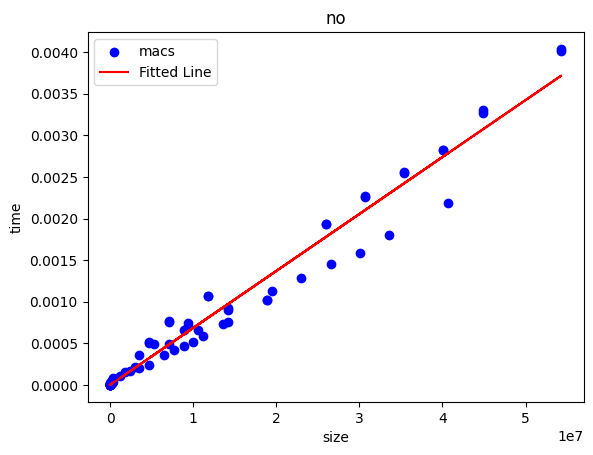

3072
54263808


In [18]:
# funcs =[
#     "tvmgen_default_fused_nn_dense",
#     "tvmgen_default_fused_nn_dense_1",
#     "tvmgen_default_fused_nn_dense_2",
#     "tvmgen_default_fused_nn_dense_3",
#     "tvmgen_default_fused_nn_dense_4",
# ]
# funcs =[
#     "tvmgen_default_fused_add",
#     "tvmgen_default_fused_add_1",
#     "tvmgen_default_fused_add_2",
#     "tvmgen_default_fused_add_3",
#     "tvmgen_default_fused_add_5",

#     "tvmgen_default_fused_add_4",
#     "tvmgen_default_fused_add_6",
#     "tvmgen_default_fused_add_7",
#     "tvmgen_default_fused_add_8",
# ]
funcs =[
    "tvmgen_default_fused_nn_batch_matmul",
    "tvmgen_default_fused_nn_batch_matmul_1",

    "tvmgen_default_fused_nn_dense",
    "tvmgen_default_fused_nn_dense_1",
    "tvmgen_default_fused_nn_dense_2",
    "tvmgen_default_fused_nn_dense_3",
    # "tvmgen_default_fused_nn_dense_4",
]

m, b = plot_func(funcs)

# really cant accept an r^2 below 0.95

IndentationError: unexpected indent (2000555992.py, line 5)

In [ ]:
y = 6.894675011954473e-11 x + -1.4073338082593907e-05
y = 6.845684637179875e-11 x + 8.258292187675319e-07